In [111]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import boto3
import random

from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.cluster import KMeans, k_means
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

In [112]:
random.seed(16)

In [2]:
# pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 400)

In [8]:
s3 = boto3.resource('s3')
bucketname = 'baseballstats'

season_stats_2018 = 'season_statistics/summary_2018.csv'
statcast_stats_2018 = 'statcast_data/sc_2018.csv'

season_obj = s3.Object(bucketname, season_stats_2018)
statcast_obj = s3.Object(bucketname, statcast_stats_2018)

In [16]:
season = season_obj.get()['Body']
statcast = statcast_obj.get()['Body']

In [17]:
season_df = pd.read_csv(season)
statcast_df = pd.read_csv(statcast)

In [20]:
season_df.head()

,Unnamed: 0,Name,Age,#days,Lev,Tm,G,PA,AB,R,H,2B,3B,HR,RBI,BB,IBB,SO,HBP,SH,SF,GDP,SB,CS,BA,OBP,SLG,OPS,mlb_ID
0,1,José Abreu,31,895,MLB-AL,Chicago,128,553,499,68,132,36,1,22,78,37,7,109,11,0,6,14,2,0,0.265,0.325,0.473,0.798,547989
1,2,Ronald Acuna Jr.,20,881,MLB-NL,Atlanta,111,487,433,78,127,26,4,26,64,45,2,123,6,0,3,4,16,4,0.293,0.366,0.552,0.917,660670
2,3,Willy Adames,22,881,MLB-AL,Tampa Bay,85,323,288,43,80,7,0,10,34,31,3,95,1,1,2,6,6,5,0.278,0.348,0.406,0.754,642715
3,4,Lane Adams,28,881,MLB-NL,Atlanta,26,29,25,10,6,1,0,2,6,4,0,8,0,0,0,1,1,0,0.240,0.345,0.520,0.865,572669
4,5,Matt Adams,29,883,MLB-NL,"St. Louis,Washington",120,337,306,42,73,10,0,21,57,27,3,73,4,0,0,6,0,0,0.239,0.309,0.477,0.786,571431


In [45]:
season_df = season_df[season_df['PA'] > 100]

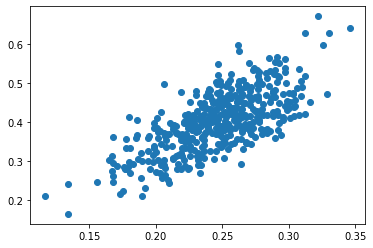

In [46]:
plt.scatter(season_df['BA'], season_df['SLG'])

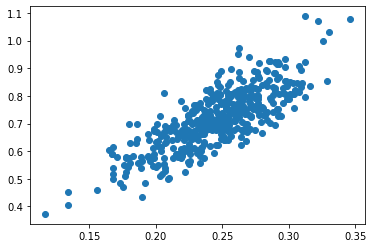

In [47]:
# Multicollinearity between Batting Average and OPS 
plt.scatter(season_df['BA'], season_df['OPS'])

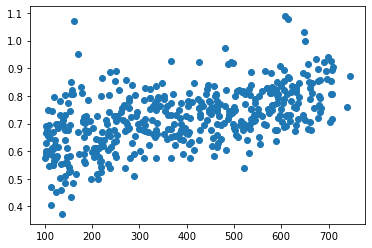

In [48]:
plt.scatter(season_df['PA'], season_df['OPS'])

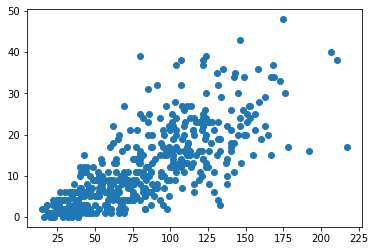

In [49]:
plt.scatter(season_df['SO'], season_df['HR'])

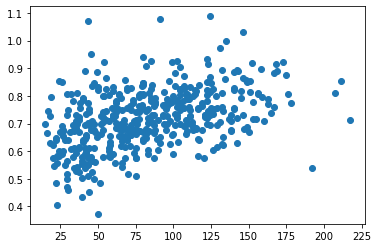

In [50]:
plt.scatter(season_df['SO'], season_df['OPS'])

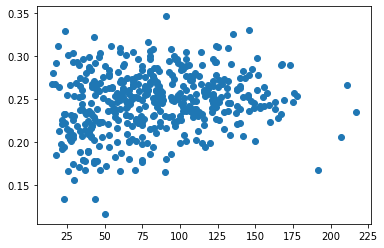

In [51]:
plt.scatter(season_df['SO'], season_df['BA'])

(array([  3.,  10.,  38.,  70., 125., 101.,  70.,  23.,   3.,   4.]),
 array([0.373 , 0.4445, 0.516 , 0.5875, 0.659 , 0.7305, 0.802 , 0.8735,
        0.945 , 1.0165, 1.088 ]),
 <BarContainer object of 10 artists>)

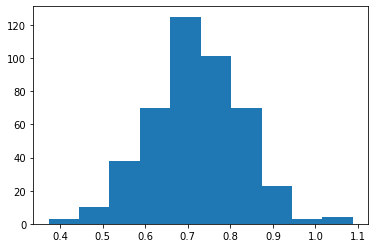

In [52]:
plt.hist(season_df['OPS'])

(array([  3.,   1.,  22.,  43.,  69., 122., 107.,  57.,  19.,   4.]),
 array([0.117 , 0.1399, 0.1628, 0.1857, 0.2086, 0.2315, 0.2544, 0.2773,
        0.3002, 0.3231, 0.346 ]),
 <BarContainer object of 10 artists>)

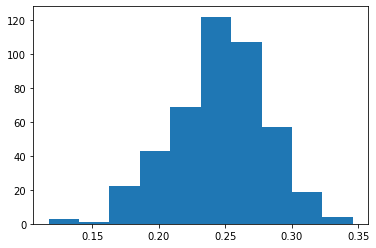

In [53]:
plt.hist(season_df['BA'])

(array([54., 80., 80., 68., 64., 51., 32., 13.,  2.,  3.]),
 array([ 15. ,  35.2,  55.4,  75.6,  95.8, 116. , 136.2, 156.4, 176.6,
        196.8, 217. ]),
 <BarContainer object of 10 artists>)

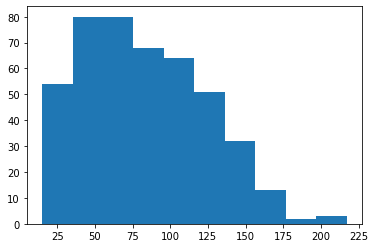

In [54]:
plt.hist(season_df['SO'])

In [102]:
player_ba_ops = season_df[['Name', 'mlb_ID', 'BA', 'OPS']]

In [103]:
player_ba_ops = player_ba_ops.set_index(['Name','mlb_ID'])

In [104]:
ss = StandardScaler()

player_ba_ops_ss = ss.fit_transform(player_ba_ops)

In [105]:
model = KMeans(n_clusters=9, random_state=0)
model.fit(player_ba_ops_ss)

KMeans(n_clusters=9, random_state=0)

In [106]:
labels = model.labels_

player_ba_ops['labels'] = labels.copy()
player_ba_ops.head()

,,BA,OPS,labels
Name,mlb_ID,,,
José Abreu,547989,0.265,0.798,0
Ronald Acuna Jr.,660670,0.293,0.917,2
Willy Adames,642715,0.278,0.754,0
Matt Adams,571431,0.239,0.786,5
Jim Adduci,451192,0.267,0.676,8


In [107]:
score = silhouette_score(player_ba_ops, labels, metric='euclidean')
score

0.9585668648828454

In [108]:
player_ba_ops['labels'].value_counts()

0    97
5    76
8    60
4    47
3    44
1    44
6    41
2    33
7     5
Name: labels, dtype: int64

In [109]:
player_ba_ops[player_ba_ops['labels'] == 2]

,,BA,OPS,labels
Name,mlb_ID,,,
Ronald Acuna Jr.,660670,0.293,0.917,2
Jesus Aguilar,542583,0.274,0.890,2
Nolan Arenado,571448,0.297,0.935,2
Javier Baez,595879,0.290,0.881,2
Charlie Blackmon,453568,0.291,0.860,2
Xander Bogaerts,593428,0.289,0.884,2
Alex Bregman,608324,0.286,0.926,2
Matt Carpenter,572761,0.257,0.897,2
Matt Chapman,656305,0.278,0.864,2


In [115]:
player_ba_ops[player_ba_ops['labels'] == 0]

,,BA,OPS,labels
Name,mlb_ID,,,
José Abreu,547989,0.265,0.798,0
Willy Adames,642715,0.278,0.754,0
Ozzie Albies,645277,0.261,0.757,0
Brian Anderson,605119,0.273,0.757,0
Harrison Bader,664056,0.264,0.756,0
Josh Bell,605137,0.261,0.768,0
Cody Bellinger,641355,0.260,0.814,0
Brandon Belt,474832,0.253,0.756,0
Adrian Beltre,134181,0.273,0.763,0


In [116]:
player_ba_ops[player_ba_ops['labels'] == 5]

,,BA,OPS,labels
Name,mlb_ID,,,
Matt Adams,571431,0.239,0.786,5
Nick Ahmed,605113,0.234,0.700,5
Yonder Alonso,475174,0.250,0.738,5
Tim Anderson,641313,0.240,0.687,5
Tyler Austin,592122,0.230,0.767,5
Tucker Barnhart,571466,0.248,0.699,5
David Bote,623520,0.239,0.727,5
Justin Bour,571506,0.227,0.746,5
Jackie Bradley Jr.,598265,0.234,0.717,5


In [117]:
player_ba_ops[player_ba_ops['labels'] == 8]

,,BA,OPS,labels
Name,mlb_ID,,,
Jim Adduci,451192,0.267,0.676,8
Ehire Adrianza,501303,0.251,0.680,8
Jorge Alfaro,595751,0.262,0.731,8
Greg Allen,656185,0.257,0.654,8
Albert Almora,546991,0.286,0.701,8
Elvis Andrus,462101,0.256,0.675,8
Welington Castillo,456078,0.259,0.710,8
Starlin Castro,516770,0.278,0.729,8
Brandon Crawford,543063,0.254,0.719,8


In [120]:
statcast_df.head(10)

,Unnamed: 0,index,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,spin_dir,spin_rate_deprecated,break_angle_deprecated,break_length_deprecated,zone,des,game_type,stand,p_throws,home_team,away_team,type,hit_location,bb_type,balls,strikes,game_year,pfx_x,pfx_z,plate_x,plate_z,on_3b,on_2b,on_1b,outs_when_up,inning,inning_topbot,hc_x,hc_y,tfs_deprecated,tfs_zulu_deprecated,fielder_2,umpire,sv_id,vx0,vy0,vz0,ax,ay,az,sz_top,sz_bot,hit_distance_sc,launch_speed,launch_angle,effective_speed,release_spin_rate,release_extension,game_pk,pitcher.1,fielder_2.1,fielder_3,fielder_4,fielder_5,fielder_6,fielder_7,fielder_8,fielder_9,release_pos_y,estimated_ba_using_speedangle,estimated_woba_using_speedangle,woba_value,woba_denom,babip_value,iso_value,launch_speed_angle,at_bat_number,pitch_number,pitch_name,home_score,away_score,bat_score,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment
0,0,0,SL,2018-10-28,84.0,3.05,5.26,Chris Sale,592518.0,519242.0,strikeout,swinging_strike,NaN,NaN,NaN,NaN,13.0,Manny Machado strikes out swinging.,W,R,L,LAD,BOS,S,2.0,NaN,1.0,2.0,2018.0,-1.35,-0.26,-1.69,0.90,NaN,NaN,NaN,2.0,9.0,Bot,NaN,NaN,NaN,NaN,543877.0,NaN,181029_031720,-8.287278,-121.937872,-3.051222,-11.346649,26.649434,-34.287809,3.49,1.60,NaN,NaN,NaN,82.9,2681.0,5.9,563411.0,519242.0,543877.0,456665.0,571788.0,646240.0,593428.0,643217.0,598265.0,605141.0,54.56,NaN,NaN,0.0,1.0,0.0,0.0,NaN,65.0,4.0,Slider,1.0,5.0,1.0,5.0,5.0,1.0,1.0,5.0,Standard,Standard
1,1,1,FF,2018-10-28,95.3,3.17,5.50,Chris Sale,592518.0,519242.0,NaN,ball,NaN,NaN,NaN,NaN,12.0,NaN,W,R,L,LAD,BOS,B,NaN,NaN,0.0,2.0,2018.0,0.83,1.26,0.16,4.48,NaN,NaN,NaN,2.0,9.0,Bot,NaN,NaN,NaN,NaN,543877.0,NaN,181029_031659,-9.701178,-138.390708,0.212266,12.883696,33.319856,-16.484654,3.74,1.72,NaN,NaN,NaN,94.6,2431.0,6.2,563411.0,519242.0,543877.0,456665.0,571788.0,646240.0,593428.0,643217.0,598265.0,605141.0,54.35,NaN,NaN,NaN,NaN,NaN,NaN,NaN,65.0,3.0,4-Seam Fastball,1.0,5.0,1.0,5.0,5.0,1.0,1.0,5.0,Standard,Standard
2,2,2,FF,2018-10-28,96.4,3.07,5.54,Chris Sale,592518.0,519242.0,NaN,foul,NaN,NaN,NaN,NaN,3.0,NaN,W,R,L,LAD,BOS,S,NaN,NaN,0.0,1.0,2018.0,1.05,1.04,0.62,3.59,NaN,NaN,NaN,2.0,9.0,Bot,NaN,NaN,NaN,NaN,543877.0,NaN,181029_031631,-8.852806,-140.120015,-1.955200,15.725661,29.903912,-18.346800,3.49,1.60,NaN,NaN,NaN,96.3,2416.0,6.2,563411.0,519242.0,543877.0,456665.0,571788.0,646240.0,593428.0,643217.0,598265.0,605141.0,54.31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,65.0,2.0,4-Seam Fastball,1.0,5.0,1.0,5.0,5.0,1.0,1.0,5.0,Standard,Standard
3,3,3,CH,2018-10-28,86.6,3.10,4.98,Chris Sale,592518.0,519242.0,NaN,swinging_strike,NaN,NaN,NaN,NaN,13.0,NaN,W,R,L,LAD,BOS,S,NaN,NaN,0.0,0.0,2018.0,1.52,-0.02,-0.10,1.39,NaN,NaN,NaN,2.0,9.0,Bot,NaN,NaN,NaN,NaN,543877.0,NaN,181029_031609,-10.697003,-125.691745,-2.299318,18.251366,25.266016,-32.130579,3.49,1.60,NaN,NaN,NaN,86.3,2177.0,6.2,563411.0,519242.0,543877.0,456665.0,571788.0,646240.0,593428.0,643217.0,598265.0,605141.0,54.27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,65.0,1.0,Changeup,1.0,5.0,1.0,5.0,5.0,1.0,1.0,5.0,Standard,Standard
4,4,4,SL,2018-10-28,78.5,3.31,5.16,Chris Sale,571771.0,519242.0,strikeout,swinging_strike,NaN,NaN,NaN,NaN,4.0,Enrique Hernandez strikes out swinging.,W,R,L,LAD,BOS,S,2.0,NaN,3.0,2.0,2018.0,-1.28,-0.25,-0.41,2.74,NaN,NaN,NaN,1.0,9.0,Bot,NaN,NaN,NaN,NaN,543877.0,NaN,181029_031528,-5.650976,-114.004641,2.039603,-9.806001,21.021107,-34.953400,3.32,1.51,NaN,NaN,NaN,77.2,2508.0,5.5,563411.0,519242.0,543877.0,456665.0,571788.0,646240.0,593428.0,643217.0,598265.0,605141.0,55.04,NaN,NaN,0.0,1.0,0.0,0.0,NaN,64.0,7.0,Slider,1.0,5.0,1.0,5.0,5.0,1.0,1.0,5.0,Standard,Standard
5,5,5,FF,2018-10-28,95.1,3.18,5.43,Chris Sale,571771.0,519242.0,NaN,foul,NaN,NaN,NaN,NaN,12.0,NaN,W,R,L,LAD,BOS,S,NaN,NaN,3.0,2.0,2018.0,0.96,1.08,0.37,3.86,NaN,NaN,NaN,1.0,9.0,Bot,NaN,NaN,NaN,NaN,543877.0,NaN,181029_031457,-9.533904,-138.181895,-0.839230,14.487991,31.581467,

In [ ]:
# , 'pitch_name'
sc_hitting = ['batter', 'game_type', 'p_throws', 'bb_type', 
            'hc_x', 'hc_y','hit_distance_sc', 'launch_speed', 'launch_angle', 
            'woba_value','babip_value', 'iso_value', 'launch_speed_angle']

In [ ]:
dummy_statcast = pd.get_dummies(['pitch_name', 'p_throws', 'bb_type', 
                                 'launch_speed_angle'], drop_first=True)

(50.0, 110.0)

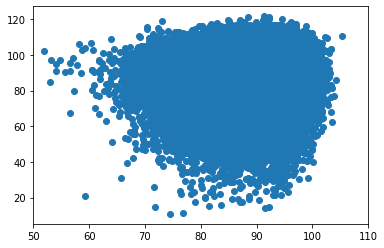

In [119]:
plt.scatter(statcast_df['effective_speed'], statcast_df['launch_speed'])
plt.xlim([50,110])

In [ ]:
vif = pd.DataFrame()

vif['vif_factor'] = [variance_inflation_factor(train[x_vars].values, i) 
                     for i in range(train[x_vars].shape[1])]

vif['features'] = x_vars